
# $K^* \mu \mu$ angular analysis - Getting started

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iminuit import Minuit

## Loading the data
Let us load the data from each bin in separate data frames, and put them in a list called `bins`.

The following assumes that the pickle file for bin i is called `toy_data_bin_i.pkl` and is located in the folder `../kstarmumu_toy_data/`.

In [2]:
data_path = 'kstarmumu_toy_data/'
files = [f'{data_path}toy_data_bin_{i}.pkl' for i in range(7)]
bins = [pd.read_pickle(file) for file in files]

bins[0].head()

,mB,ctl,ctk,phi,mkpi,eff,year,pol,id
0,75.956925,-0.986918,0.116878,-2.855914,1.035573,1.0,2012,1.0,1
1,121.280030,-0.657315,0.514766,0.317335,0.987207,1.0,2012,1.0,1
2,90.329200,-0.840377,0.309197,0.939818,0.927182,1.0,2012,-1.0,1
3,84.977505,-0.278589,-0.883990,2.403850,0.800599,1.0,2012,-1.0,1
4,106.125464,0.292535,0.422031,-0.377728,0.925444,1.0,2012,1.0,1


Let us have a look at the distribution of the variable $cos(\theta_l)$, which will be used below, in one of the bins.

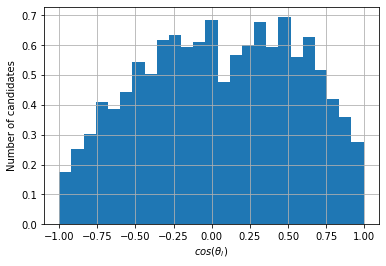

In [3]:
plt.hist(bins[3]['ctl'], bins=25, density=True)
plt.xlabel(r'$cos(\theta_l)$')
plt.ylabel(r'Number of candidates')
plt.grid()
plt.show()

## Fitting
Let us assume a flat acceptance distribution for the following.
We have
$\frac{d^2\Gamma_P}{dq^2dcos\theta_l} = \frac{3}{8}[\frac{3}{2} - \frac{1}{2}F_L + \frac{1}{2}cos2\theta_l(1-3F_L) + \frac{8}{3}A_{FB}cos\theta_l]$

In [4]:
def d2gamma_p_d2q2_dcostheta(fl, afb, cos_theta_l):
    """
    Returns the pdf defined above
    :param fl: f_l observable
    :param afb: a_fb observable
    :param cos_theta_l: cos(theta_l)
    :return:
    """
    ctl = cos_theta_l
    c2tl = 2 * ctl ** 2 - 1
    acceptance = 0.5  # acceptance "function"
    scalar_array = 3/8 * (3/2 - 1/2 * fl + 1/2 * c2tl * (1 - 3 * fl) + 8/3 * afb * ctl) * acceptance
    normalised_scalar_array = scalar_array * 2  # normalising scalar array to account for the non-unity acceptance function
    return normalised_scalar_array

def log_likelihood(fl, afb, _bin):
    """
    Returns the negative log-likelihood of the pdf defined above
    :param fl: f_l observable
    :param afb: a_fb observable
    :param _bin: number of the bin to fit
    :return:
    """
    _bin = bins[int(_bin)]
    ctl = _bin['ctl']
    normalised_scalar_array = d2gamma_p_d2q2_dcostheta(fl=fl, afb=afb, cos_theta_l=ctl)
    return - np.sum(np.log(normalised_scalar_array))

Let us check how the negative log-likelihood function defined above looks like for a given bin and a fixed $A_{FB}$ or a fixed $F_L$.

/home/ht616/Documents/kstarmumu_course/ic-teach-kstmumu-public/venv/lib64/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ht616/Documents/kstarmumu_course/ic-teach-kstmumu-public/venv/lib64/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


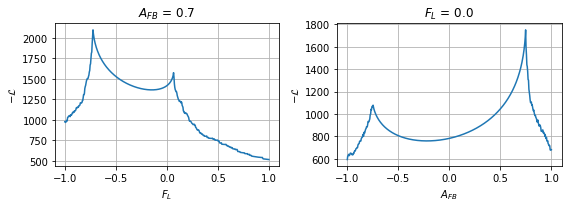

In [5]:
_test_bin = 1
_test_afb = 0.7
_test_fl = 0.0

x = np.linspace(-1, 1, 500)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(x, [log_likelihood(fl=i, afb=_test_afb, _bin=_test_bin) for i in x])
ax1.set_title(r'$A_{FB}$ = ' + str(_test_afb))
ax1.set_xlabel(r'$F_L$')
ax1.set_ylabel(r'$-\mathcal{L}$')
ax1.grid()
ax2.plot(x, [log_likelihood(fl=_test_fl, afb=i, _bin=_test_bin) for i in x])
ax2.set_title(r'$F_{L}$ = ' + str(_test_fl))
ax2.set_xlabel(r'$A_{FB}$')
ax2.set_ylabel(r'$-\mathcal{L}$')
ax2.grid()
plt.tight_layout()
plt.show()

### Fitting
We then use `iminuit` to optimize $A_{FB}$ and $F_L$.

In [6]:
bin_number_to_check = 0  # bin that we want to check in more details in the next cell
bin_results_to_check = None

log_likelihood.errordef = Minuit.LIKELIHOOD
decimal_places = 3
starting_point = [-0.1,0.0]
fls, fl_errs = [], []
afbs, afb_errs = [], []
for i in range(len(bins)):
    m = Minuit(log_likelihood, fl=starting_point[0], afb=starting_point[1], _bin=i)
    m.fixed['_bin'] = True  # fixing the bin number as we don't want to optimize it
    m.limits=((-1.0, 1.0), (-1.0, 1.0), None)
    m.migrad()
    m.hesse()
    if i == bin_number_to_check:
        bin_results_to_check = m
    fls.append(m.values[0])
    afbs.append(m.values[1])
    fl_errs.append(m.errors[0])
    afb_errs.append(m.errors[1])
    print(f"Bin {i}: {np.round(fls[i], decimal_places)} pm {np.round(fl_errs[i], decimal_places)},", f"{np.round(afbs[i], decimal_places)} pm {np.round(afb_errs[i], decimal_places)}. Function minimum considered valid: {m.fmin.is_valid}")

Bin 0: 0.293 pm 0.037, -0.099 pm 0.021. Function minimum considered valid: True
Bin 1: 0.652 pm 0.038, -0.187 pm 0.023. Function minimum considered valid: True
Bin 2: 0.738 pm 0.041, -0.097 pm 0.023. Function minimum considered valid: True
Bin 3: 0.722 pm 0.033, 0.072 pm 0.019. Function minimum considered valid: True
Bin 4: 0.651 pm 0.028, 0.215 pm 0.017. Function minimum considered valid: True
Bin 5: 0.299 pm 0.034, 0.383 pm 0.02. Function minimum considered valid: True
Bin 6: 0.239 pm 0.042, 0.332 pm 0.024. Function minimum considered valid: True


/home/ht616/Documents/kstarmumu_course/ic-teach-kstmumu-public/venv/lib64/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Let us also look at the profiles for $A_{FB}$ and $F_L$ for a bin (e.g. bin number 0).

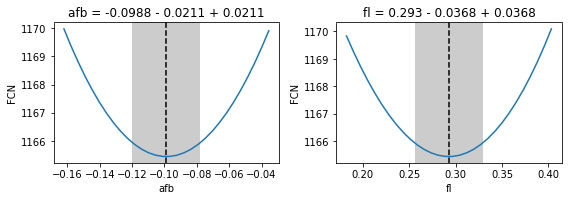

In [7]:
plt.figure(figsize=(8, 5))
plt.subplot(221)
bin_results_to_check.draw_mnprofile('afb', bound=3)
plt.subplot(222)
bin_results_to_check.draw_mnprofile('fl', bound=3)
plt.tight_layout()
plt.show()

We can also plot the resulting fitted PDF over the measured $cos(\theta_l)$ distribution.

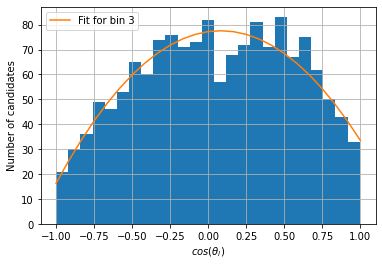

In [8]:
bin_to_plot = 3
number_of_bins_in_hist = 25
cos_theta_l_bin = bins[bin_to_plot]['ctl']
hist, _bins, _ = plt.hist(cos_theta_l_bin, bins=number_of_bins_in_hist)
x = np.linspace(-1, 1, number_of_bins_in_hist)
pdf_multiplier = np.sum(hist) * (np.max(cos_theta_l_bin) - np.min(cos_theta_l_bin)) / number_of_bins_in_hist
y = d2gamma_p_d2q2_dcostheta(fl=fls[bin_to_plot], afb=afbs[bin_to_plot], cos_theta_l=x) * pdf_multiplier
plt.plot(x, y, label=f'Fit for bin {bin_to_plot}')
plt.xlabel(r'$cos(\theta_l)$')
plt.ylabel(r'Number of candidates')
plt.legend()
plt.grid()
plt.show()

Finally, let us visualize the results in each bin.

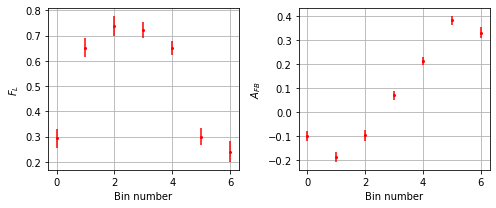

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
ax1.errorbar(np.linspace(0, len(bins) - 1, len(bins)), fls, yerr=fl_errs, fmt='o', markersize=2, label=r'$F_L$', color='red')
ax2.errorbar(np.linspace(0, len(bins) - 1, len(bins)), afbs, yerr=afb_errs, fmt='o', markersize=2, label=r'$A_{FB}$', color='red')
ax1.grid()
ax2.grid()
ax1.set_ylabel(r'$F_L$')
ax2.set_ylabel(r'$A_{FB}$')
ax1.set_xlabel(r'Bin number')
ax2.set_xlabel(r'Bin number')
plt.tight_layout()
plt.show()
